In [31]:
import requests 
import plotly.offline as py
import pandas as pd
from datetime import datetime
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.models import load_model
import matplotlib.pyplot as plt

In [32]:
trans_withBlock_group = pd.read_csv('parking_meter/trans_withBlock_group.csv').drop(columns = ['Unnamed: 0'])
trans_129 = trans_withBlock_group[(trans_withBlock_group['str_block_id'] == '129_HIGH ST N')].reset_index(drop=True)
trans_129['timestamp'] = pd.to_datetime(trans_129['timestamp'])
trans_129 = trans_129.set_index("timestamp")
trans_129['availableRate'] = trans_129['available']/trans_129['pole']

In [35]:
trans_129 = trans_129.between_time('08:00', '22:00', include_start = True, include_end = False) 
trans_129 = trans_129[(trans_129.index.dayofweek != 6)] # exclude sunday

In [37]:
weather_new = pd.read_csv('weather/weather_data_2015-08.csv', index_col = 0)
weather_new['timestamp'] = pd.to_datetime(weather_new['time'].str.replace('-04:00',''), format = "%Y-%m-%d %H:%M:%S")
weather_new = weather_new.set_index("timestamp").resample("30T").asfreq().ffill().reset_index()

In [38]:
trans_129_weather = trans_129.join(weather_new.set_index('timestamp'), on = 'timestamp')

In [39]:
trans_129_weather.iloc[:,6:11].head()

,availableRate,apparent_temperature,cloud_cover,dew_point,humidity
timestamp,,,,,
2015-08-01 08:00:00,0.916667,67.35,0.0,60.40,0.79
2015-08-01 08:30:00,0.666667,67.35,0.0,60.40,0.79
2015-08-01 09:00:00,0.666667,72.46,0.0,59.72,0.64
2015-08-01 09:30:00,0.500000,72.46,0.0,59.72,0.64
2015-08-01 10:00:00,0.083333,75.82,0.0,59.32,0.57


In [40]:
trans_129_weather.shape

(700, 25)

In [154]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = trans_129_weather.iloc[:,6]
values = dataset.values.reshape(-1, 1)
timelags = 29
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, timelags, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[3:-3], axis=1, inplace=True)
print(reframed.head())

    var1(t-29)  var1(t-28)  var1(t-27)  var1(t-2)  var1(t-1)   var1(t)
29    0.916667    0.666667    0.666667   0.000000   0.750000  0.916667
30    0.666667    0.666667    0.500000   0.750000   0.916667  0.916667
31    0.666667    0.500000    0.083333   0.916667   0.916667  0.916667
32    0.500000    0.083333    0.000000   0.916667   0.916667  0.750000
33    0.083333    0.000000    0.000000   0.916667   0.750000  0.416667


In [155]:
values = reframed.values
# timevars = timelags
timevars = 5
n_train_hours = len(values)//4*3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# train_X, train_y = train[:, :-timevars], train[:, -timevars:]
# test_X, test_y = test[:, :-timevars], test[:, :-timevars]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timevars, 1))
test_X = test_X.reshape((test_X.shape[0], timevars, 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(501, 5, 1) (501,) (170, 5, 1) (170,)


Train on 501 samples, validate on 170 samples
Epoch 1/500
 - 1s - loss: 0.0553 - val_loss: 0.0378
Epoch 2/500
 - 0s - loss: 0.0316 - val_loss: 0.0337
Epoch 3/500
 - 0s - loss: 0.0264 - val_loss: 0.0312
Epoch 4/500
 - 0s - loss: 0.0249 - val_loss: 0.0310
Epoch 5/500
 - 0s - loss: 0.0245 - val_loss: 0.0310
Epoch 6/500
 - 0s - loss: 0.0244 - val_loss: 0.0307
Epoch 7/500
 - 0s - loss: 0.0243 - val_loss: 0.0305
Epoch 8/500
 - 0s - loss: 0.0242 - val_loss: 0.0302
Epoch 9/500
 - 0s - loss: 0.0241 - val_loss: 0.0301
Epoch 10/500
 - 0s - loss: 0.0240 - val_loss: 0.0299
Epoch 11/500
 - 0s - loss: 0.0239 - val_loss: 0.0297
Epoch 12/500
 - 0s - loss: 0.0238 - val_loss: 0.0295
Epoch 13/500
 - 0s - loss: 0.0238 - val_loss: 0.0293
Epoch 14/500
 - 0s - loss: 0.0237 - val_loss: 0.0292
Epoch 15/500
 - 0s - loss: 0.0236 - val_loss: 0.0290
Epoch 16/500
 - 0s - loss: 0.0236 - val_loss: 0.0289
Epoch 17/500
 - 0s - loss: 0.0235 - val_loss: 0.0287
Epoch 18/500
 - 0s - loss: 0.0234 - val_loss: 0.0286
Epoch 19/

Epoch 154/500
 - 0s - loss: 0.0103 - val_loss: 0.0131
Epoch 155/500
 - 0s - loss: 0.0103 - val_loss: 0.0131
Epoch 156/500
 - 0s - loss: 0.0102 - val_loss: 0.0130
Epoch 157/500
 - 0s - loss: 0.0102 - val_loss: 0.0130
Epoch 158/500
 - 0s - loss: 0.0102 - val_loss: 0.0130
Epoch 159/500
 - 0s - loss: 0.0102 - val_loss: 0.0129
Epoch 160/500
 - 0s - loss: 0.0102 - val_loss: 0.0129
Epoch 161/500
 - 0s - loss: 0.0101 - val_loss: 0.0129
Epoch 162/500
 - 0s - loss: 0.0101 - val_loss: 0.0128
Epoch 163/500
 - 0s - loss: 0.0101 - val_loss: 0.0128
Epoch 164/500
 - 0s - loss: 0.0101 - val_loss: 0.0127
Epoch 165/500
 - 0s - loss: 0.0101 - val_loss: 0.0127
Epoch 166/500
 - 0s - loss: 0.0101 - val_loss: 0.0127
Epoch 167/500
 - 0s - loss: 0.0100 - val_loss: 0.0126
Epoch 168/500
 - 0s - loss: 0.0100 - val_loss: 0.0126
Epoch 169/500
 - 0s - loss: 0.0100 - val_loss: 0.0126
Epoch 170/500
 - 0s - loss: 0.0100 - val_loss: 0.0126
Epoch 171/500
 - 0s - loss: 0.0100 - val_loss: 0.0125
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0087 - val_loss: 0.0102
Epoch 307/500
 - 0s - loss: 0.0086 - val_loss: 0.0102
Epoch 308/500
 - 0s - loss: 0.0086 - val_loss: 0.0102
Epoch 309/500
 - 0s - loss: 0.0086 - val_loss: 0.0102
Epoch 310/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 311/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 312/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 313/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 314/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 315/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 316/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 317/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 318/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 319/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 320/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 321/500
 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 322/500
 - 0s - loss: 0.0086 - val_loss: 0.0100
Epoch 323/500
 - 0s - loss: 0.0086 - val_loss: 0.0100
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0079 - val_loss: 0.0091
Epoch 459/500
 - 0s - loss: 0.0079 - val_loss: 0.0091
Epoch 460/500
 - 0s - loss: 0.0079 - val_loss: 0.0091
Epoch 461/500
 - 0s - loss: 0.0079 - val_loss: 0.0091
Epoch 462/500
 - 0s - loss: 0.0079 - val_loss: 0.0091
Epoch 463/500
 - 0s - loss: 0.0079 - val_loss: 0.0090
Epoch 464/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 465/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 466/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 467/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 468/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 469/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 470/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 471/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 472/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 473/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 474/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 475/500
 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 476/500
 - 0s - loss: 

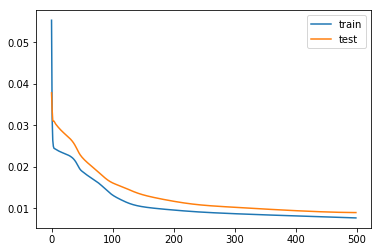

In [117]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size= 32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

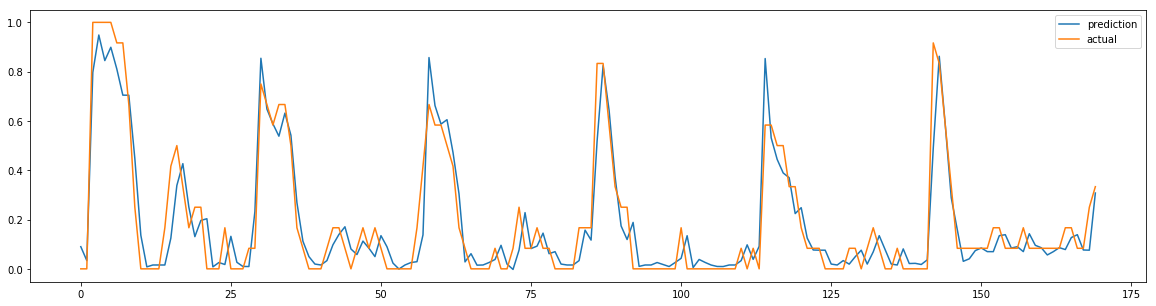

In [118]:
plt.figure(figsize=(20,5))
yhat = model.predict(test_X)
# plt.plot(X_test.reshape(len(X_test),1)[:100], label = 'input')
plt.plot(yhat[:], label = 'prediction')
plt.plot(test_y[:], label = 'actual')
plt.legend()
plt.show()

In [13]:
# plt.figure(figsize=(20,5))
# yhat = model.predict(test_X)
# # plt.plot(X_test.reshape(len(X_test),1)[:100], label = 'input')
# plt.plot(yhat[:], label = 'prediction')
# plt.plot(test_y[:], label = 'actual')
# plt.legend()
# plt.show()

In [119]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from math import sqrt

In [852]:
# # make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
inv_yhat.shape
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Baseline RMSE: %.3f' % sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])))

Test RMSE: 0.122
Baseline RMSE: 0.147


In [120]:
# # make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :-1]), axis=1)
inv_yhat.shape
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Baseline RMSE: %.3f' % sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])))

Test RMSE: 0.095
Baseline RMSE: 0.171


### use all the data

In [122]:
trans_withBlock_group.head()

,timestamp,sub area,block_id,block_name,pole,available,str_block_id
0,2015-08-01 00:00:00,ARMSTRONG ST N,8,"ALY,ARMSTRONG,SCHOOL,VINE",6,6,8_ARMSTRONG ST N
1,2015-08-01 00:00:00,ARMSTRONG ST N,14,"ARMSTRONG,MIDDLE,SPRUCE,VINE",7,7,14_ARMSTRONG ST N
2,2015-08-01 00:00:00,ARMSTRONG ST N,17,"ARMSTRONG,HUNT,SCHOOL,SPRUCE",6,6,17_ARMSTRONG ST N
3,2015-08-01 00:00:00,BUTTLES AVE,70,"BUTTLES,HIGH,HUBBARD,WALL",3,3,70_BUTTLES AVE
4,2015-08-01 00:00:00,BUTTLES LOT,44,"BUTTLES,HIGH,LINCOLN,WALL",45,45,44_BUTTLES LOT


In [127]:
trans_all = trans_withBlock_group.groupby('timestamp').agg({'pole':'sum','available':'sum'}).reset_index()
trans_all['timestamp'] = pd.to_datetime(trans_all['timestamp'])
trans_all = trans_all.set_index("timestamp")
trans_all['availableRate'] = trans_all['available']/trans_all['pole']
trans_all = trans_all.between_time('08:00', '22:00', include_start = True, include_end = False) 
trans_all = trans_all[(trans_all.index.dayofweek != 6)] # exclude sunday
trans_all = trans_all.join(weather_new.set_index('timestamp'), on = 'timestamp')
trans_all.head()

,pole,available,availableRate,apparent_temperature,cloud_cover,dew_point,humidity,icon,ozone,precip_intensity,...,precip_type,pressure,summary,temperature,time,uv_index,visibility,wind_bearing,wind_gust,wind_speed
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-08-01 08:00:00,839,726,0.865316,67.35,0.0,60.40,0.79,clear-day,NaN,0.0,...,NaN,1014.18,Clear,67.23,2015-08-01 08:00:00-04:00,1.0,5.603,303.0,2.99,1.37
2015-08-01 08:30:00,839,678,0.808105,67.35,0.0,60.40,0.79,clear-day,NaN,0.0,...,NaN,1014.18,Clear,67.23,2015-08-01 08:00:00-04:00,1.0,5.603,303.0,2.99,1.37
2015-08-01 09:00:00,839,616,0.734207,72.46,0.0,59.72,0.64,clear-day,NaN,0.0,...,NaN,1014.60,Clear,72.46,2015-08-01 09:00:00-04:00,2.0,4.311,310.0,6.02,2.90
2015-08-01 09:30:00,839,547,0.651967,72.46,0.0,59.72,0.64,clear-day,NaN,0.0,...,NaN,1014.60,Clear,72.46,2015-08-01 09:00:00-04:00,2.0,4.311,310.0,6.02,2.90
2015-08-01 10:00:00,839,478,0.569726,75.82,0.0,59.32,0.57,clear-day,NaN,0.0,...,NaN,1014.78,Clear,75.82,2015-08-01 10:00:00-04:00,4.0,4.648,312.0,8.24,3.69


In [128]:
# load dataset
dataset = trans_all.iloc[:,2]
values = dataset.values.reshape(-1, 1)
timelags = 30
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, timelags, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
print(reframed.head())

    var1(t-30)  var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  var1(t-25)  \
30    0.949480    0.878157    0.786033    0.683507    0.580981    0.488856   
31    0.878157    0.786033    0.683507    0.580981    0.488856    0.402675   
32    0.786033    0.683507    0.580981    0.488856    0.402675    0.320951   
33    0.683507    0.580981    0.488856    0.402675    0.320951    0.246657   
34    0.580981    0.488856    0.402675    0.320951    0.246657    0.225854   

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)    ...     var1(t-9)  \
30    0.402675    0.320951    0.246657    0.225854    ...      0.071322   
31    0.320951    0.246657    0.225854    0.181278    ...      0.071322   
32    0.246657    0.225854    0.181278    0.157504    ...      0.072808   
33    0.225854    0.181278    0.157504    0.164933    ...      0.083209   
34    0.181278    0.157504    0.164933    0.164933    ...      0.109955   

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
30   0.0

In [125]:
values = reframed.values
n_train_hours = 20 * timelags
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timelags, 1))
test_X = test_X.reshape((test_X.shape[0], timelags, 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(600, 30, 1) (600,) (210, 30, 1) (210,)


In [131]:
values = reframed.values
n_train_hours = 18 * timelags
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timelags, 1))
test_X = test_X.reshape((test_X.shape[0], timelags, 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(540, 30, 1) (540,) (130, 30, 1) (130,)


Train on 600 samples, validate on 210 samples
Epoch 1/250
 - 1s - loss: 0.2392 - val_loss: 0.1526
Epoch 2/250
 - 0s - loss: 0.1076 - val_loss: 0.0673
Epoch 3/250
 - 0s - loss: 0.0785 - val_loss: 0.0745
Epoch 4/250
 - 0s - loss: 0.0738 - val_loss: 0.0606
Epoch 5/250
 - 0s - loss: 0.0643 - val_loss: 0.0619
Epoch 6/250
 - 0s - loss: 0.0639 - val_loss: 0.0596
Epoch 7/250
 - 0s - loss: 0.0609 - val_loss: 0.0552
Epoch 8/250
 - 0s - loss: 0.0584 - val_loss: 0.0533
Epoch 9/250
 - 0s - loss: 0.0568 - val_loss: 0.0518
Epoch 10/250
 - 0s - loss: 0.0549 - val_loss: 0.0505
Epoch 11/250
 - 0s - loss: 0.0534 - val_loss: 0.0495
Epoch 12/250
 - 0s - loss: 0.0520 - val_loss: 0.0480
Epoch 13/250
 - 0s - loss: 0.0506 - val_loss: 0.0466
Epoch 14/250
 - 0s - loss: 0.0492 - val_loss: 0.0454
Epoch 15/250
 - 0s - loss: 0.0478 - val_loss: 0.0443
Epoch 16/250
 - 0s - loss: 0.0466 - val_loss: 0.0433
Epoch 17/250
 - 0s - loss: 0.0454 - val_loss: 0.0423
Epoch 18/250
 - 0s - loss: 0.0443 - val_loss: 0.0413
Epoch 19/

Epoch 154/250
 - 0s - loss: 0.0055 - val_loss: 0.0040
Epoch 155/250
 - 0s - loss: 0.0055 - val_loss: 0.0040
Epoch 156/250
 - 0s - loss: 0.0055 - val_loss: 0.0040
Epoch 157/250
 - 0s - loss: 0.0054 - val_loss: 0.0039
Epoch 158/250
 - 0s - loss: 0.0053 - val_loss: 0.0038
Epoch 159/250
 - 0s - loss: 0.0053 - val_loss: 0.0038
Epoch 160/250
 - 0s - loss: 0.0053 - val_loss: 0.0038
Epoch 161/250
 - 0s - loss: 0.0053 - val_loss: 0.0038
Epoch 162/250
 - 0s - loss: 0.0052 - val_loss: 0.0037
Epoch 163/250
 - 0s - loss: 0.0052 - val_loss: 0.0037
Epoch 164/250
 - 0s - loss: 0.0052 - val_loss: 0.0036
Epoch 165/250
 - 0s - loss: 0.0052 - val_loss: 0.0036
Epoch 166/250
 - 0s - loss: 0.0051 - val_loss: 0.0036
Epoch 167/250
 - 0s - loss: 0.0050 - val_loss: 0.0035
Epoch 168/250
 - 0s - loss: 0.0050 - val_loss: 0.0035
Epoch 169/250
 - 0s - loss: 0.0050 - val_loss: 0.0035
Epoch 170/250
 - 0s - loss: 0.0050 - val_loss: 0.0035
Epoch 171/250
 - 0s - loss: 0.0049 - val_loss: 0.0034
Epoch 172/250
 - 0s - loss: 

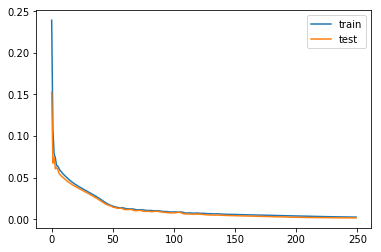

In [681]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size= 100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 540 samples, validate on 130 samples
Epoch 1/300
 - 1s - loss: 0.1708 - val_loss: 0.0999
Epoch 2/300
 - 0s - loss: 0.1123 - val_loss: 0.0666
Epoch 3/300
 - 0s - loss: 0.0751 - val_loss: 0.0588
Epoch 4/300
 - 0s - loss: 0.0670 - val_loss: 0.0736
Epoch 5/300
 - 0s - loss: 0.0742 - val_loss: 0.0705
Epoch 6/300
 - 0s - loss: 0.0681 - val_loss: 0.0599
Epoch 7/300
 - 0s - loss: 0.0616 - val_loss: 0.0551
Epoch 8/300
 - 0s - loss: 0.0604 - val_loss: 0.0540
Epoch 9/300
 - 0s - loss: 0.0609 - val_loss: 0.0534
Epoch 10/300
 - 0s - loss: 0.0604 - val_loss: 0.0525
Epoch 11/300
 - 0s - loss: 0.0589 - val_loss: 0.0517
Epoch 12/300
 - 0s - loss: 0.0571 - val_loss: 0.0515
Epoch 13/300
 - 0s - loss: 0.0559 - val_loss: 0.0517
Epoch 14/300
 - 0s - loss: 0.0552 - val_loss: 0.0518
Epoch 15/300
 - 0s - loss: 0.0545 - val_loss: 0.0511
Epoch 16/300
 - 0s - loss: 0.0536 - val_loss: 0.0499
Epoch 17/300
 - 0s - loss: 0.0527 - val_loss: 0.0486
Epoch 18/300
 - 0s - loss: 0.0519 - val_loss: 0.0476
Epoch 19/

Epoch 154/300
 - 0s - loss: 0.0110 - val_loss: 0.0089
Epoch 155/300
 - 0s - loss: 0.0110 - val_loss: 0.0089
Epoch 156/300
 - 0s - loss: 0.0109 - val_loss: 0.0089
Epoch 157/300
 - 0s - loss: 0.0109 - val_loss: 0.0088
Epoch 158/300
 - 0s - loss: 0.0108 - val_loss: 0.0088
Epoch 159/300
 - 0s - loss: 0.0108 - val_loss: 0.0087
Epoch 160/300
 - 0s - loss: 0.0107 - val_loss: 0.0087
Epoch 161/300
 - 0s - loss: 0.0107 - val_loss: 0.0087
Epoch 162/300
 - 0s - loss: 0.0106 - val_loss: 0.0086
Epoch 163/300
 - 0s - loss: 0.0106 - val_loss: 0.0086
Epoch 164/300
 - 0s - loss: 0.0105 - val_loss: 0.0085
Epoch 165/300
 - 0s - loss: 0.0105 - val_loss: 0.0085
Epoch 166/300
 - 0s - loss: 0.0104 - val_loss: 0.0085
Epoch 167/300
 - 0s - loss: 0.0104 - val_loss: 0.0084
Epoch 168/300
 - 0s - loss: 0.0103 - val_loss: 0.0084
Epoch 169/300
 - 0s - loss: 0.0103 - val_loss: 0.0083
Epoch 170/300
 - 0s - loss: 0.0102 - val_loss: 0.0083
Epoch 171/300
 - 0s - loss: 0.0102 - val_loss: 0.0082
Epoch 172/300
 - 0s - loss: 

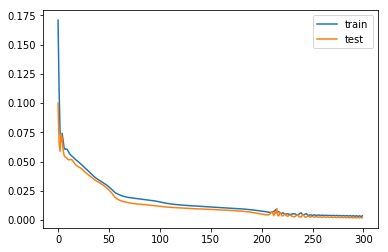

In [133]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size= 200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

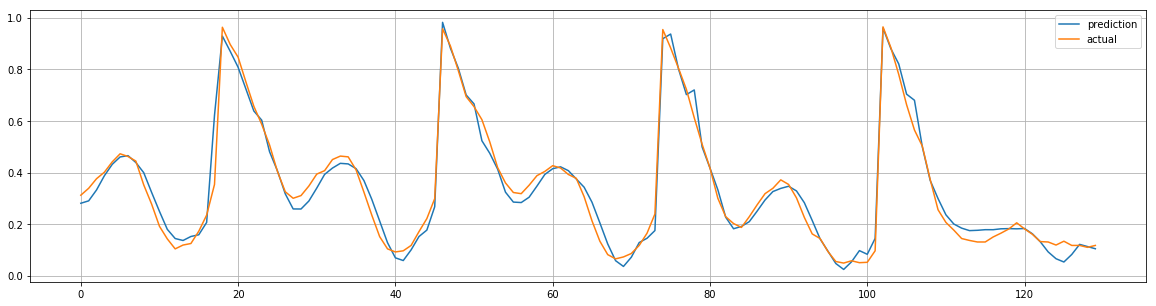

In [137]:
plt.figure(figsize=(20,5))
yhat = model.predict(test_X)
# plt.plot(X_test.reshape(len(X_test),1)[:100], label = 'input')
plt.plot(yhat, label = 'prediction')
plt.plot(test_y, label = 'actual')
plt.legend()
plt.grid(True)
plt.show()

In [138]:
# # make a prediction
yhat = model.predict(test_X)
# # invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.034


In [139]:
# save model to single file
model.save('lstm_model.h5')

In [140]:
# snip...
# later, perhaps run from another script
 
# load model from single file
model = load_model('lstm_model.h5')

In [141]:
# # make a prediction
yhat = model.predict(test_X)
# # invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Baseline RMSE: %.3f' % sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])))

Test RMSE: 0.034
Baseline RMSE: 0.111


In [142]:
### add weather to the model not as good

In [143]:
# load dataset
dataset = trans_all.iloc[:,[2,6,9,14,17]]
values = dataset.values
timelags = 30
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, timelags, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3,-4]], axis=1, inplace=True)
print(reframed.head())

    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var1(t-29)  \
30    0.949480    0.727273         0.0    0.371838    0.734553    0.878157   
31    0.878157    0.727273         0.0    0.371838    0.734553    0.786033   
32    0.786033    0.454545         0.0    0.545939    0.511564    0.683507   
33    0.683507    0.454545         0.0    0.545939    0.511564    0.580981   
34    0.580981    0.327273         0.0    0.657789    0.569727    0.488856   

    var2(t-29)  var3(t-29)  var4(t-29)  var5(t-29)    ...     var2(t-2)  \
30    0.727273         0.0    0.371838    0.734553    ...      0.909091   
31    0.454545         0.0    0.545939    0.511564    ...      0.909091   
32    0.454545         0.0    0.545939    0.511564    ...      0.818182   
33    0.327273         0.0    0.657789    0.569727    ...      0.818182   
34    0.327273         0.0    0.657789    0.569727    ...      0.618182   

    var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  \
30   0.4

In [147]:
values = reframed.values
n_train_hours = 17 * timelags
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timelags, 5))
test_X = test_X.reshape((test_X.shape[0], timelags, 5))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(510, 30, 5) (510,) (160, 30, 5) (160,)


Train on 510 samples, validate on 160 samples
Epoch 1/150
 - 1s - loss: 0.2896 - val_loss: 0.1124
Epoch 2/150
 - 0s - loss: 0.0889 - val_loss: 0.0676
Epoch 3/150
 - 0s - loss: 0.0957 - val_loss: 0.0790
Epoch 4/150
 - 0s - loss: 0.0768 - val_loss: 0.0571
Epoch 5/150
 - 0s - loss: 0.0553 - val_loss: 0.0532
Epoch 6/150
 - 0s - loss: 0.0526 - val_loss: 0.0511
Epoch 7/150
 - 0s - loss: 0.0507 - val_loss: 0.0481
Epoch 8/150
 - 0s - loss: 0.0491 - val_loss: 0.0466
Epoch 9/150
 - 0s - loss: 0.0480 - val_loss: 0.0450
Epoch 10/150
 - 0s - loss: 0.0451 - val_loss: 0.0425
Epoch 11/150
 - 0s - loss: 0.0416 - val_loss: 0.0407
Epoch 12/150
 - 0s - loss: 0.0391 - val_loss: 0.0395
Epoch 13/150
 - 0s - loss: 0.0374 - val_loss: 0.0386
Epoch 14/150
 - 0s - loss: 0.0360 - val_loss: 0.0382
Epoch 15/150
 - 0s - loss: 0.0347 - val_loss: 0.0386
Epoch 16/150
 - 0s - loss: 0.0339 - val_loss: 0.0392
Epoch 17/150
 - 0s - loss: 0.0336 - val_loss: 0.0391
Epoch 18/150
 - 0s - loss: 0.0332 - val_loss: 0.0384
Epoch 19/

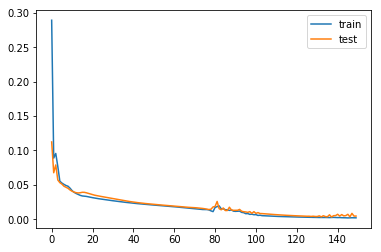

In [148]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size= 100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

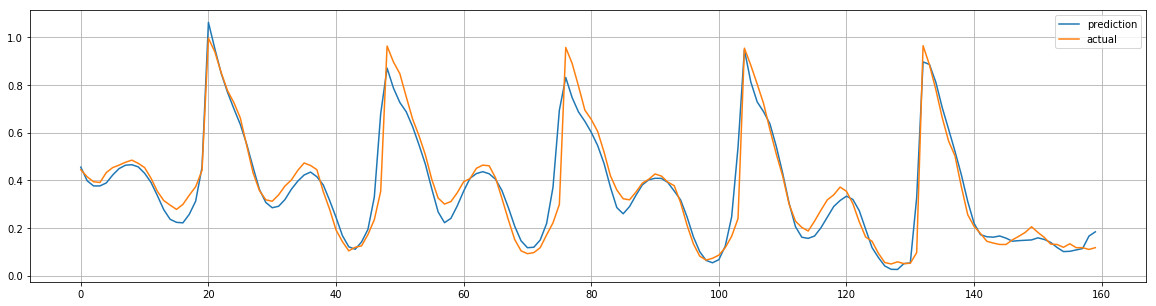

In [149]:
plt.figure(figsize=(20,5))
yhat = model.predict(test_X)
# plt.plot(X_test.reshape(len(X_test),1)[:100], label = 'input')
plt.plot(yhat, label = 'prediction')
plt.plot(test_y, label = 'actual')
plt.legend()
plt.grid(True)
plt.show()

In [150]:
# # make a prediction
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,0,1:]), axis=1)
inv_yhat.shape
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,0,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Baseline RMSE: %.3f' % sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])))

Test RMSE: 0.054
Baseline RMSE: 0.108


### predict using all pole data, not aggregated

In [14]:
trans_withBlock_group['str_block_id'].unique()

array(['8_ARMSTRONG ST N', '14_ARMSTRONG ST N', '17_ARMSTRONG ST N',
       '70_BUTTLES AVE', '44_BUTTLES LOT', '87_FIRST AVE W',
       '101_FIRST AVE W', '175_FOURTH AVE', '179_FOURTH AVE',
       '181_FOURTH AVE', '201_FOURTH AVE', '24_GOODALE ST W',
       '47_GOODALE ST W', '181_GREENWOOD LOT', '202_GREENWOOD LOT',
       '204_GREENWOOD LOT', '9_HIGH ST N', '21_HIGH ST N', '23_HIGH ST N',
       '25_HIGH ST N', '37_HIGH ST N', '42_HIGH ST N', '59_HIGH ST N',
       '64_HIGH ST N', '70_HIGH ST N', '86_HIGH ST N', '87_HIGH ST N',
       '101_HIGH ST N', '114_HIGH ST N', '129_HIGH ST N', '130_HIGH ST N',
       '146_HIGH ST N', '147_HIGH ST N', '166_HIGH ST N', '175_HIGH ST N',
       '181_HIGH ST N', '201_HIGH ST N', '202_HIGH ST N',
       '27_HIGH ST N ON CAP', '28_HIGH ST N ON CAP',
       '31_HIGH ST N ON CAP', '36_HIGH ST N ON CAP',
       '44_HIGH ST N ON CAP', '59_HIGH ST N ON CAP', '86_HUBBARD AVE E',
       '70_HUBBARD AVE W', '42_LINCOLN ST E', '46_LINCOLN ST E',
       '1

In [15]:
reframed_all = pd.DataFrame()
for pole_id in trans_withBlock_group['str_block_id'].unique():
    trans_single = trans_withBlock_group[(trans_withBlock_group['str_block_id'] == pole_id)].reset_index(drop=True)
    trans_single['timestamp'] = pd.to_datetime(trans_single['timestamp'])
    trans_single = trans_single.set_index("timestamp")
    trans_single['availableRate'] = trans_single['available']/trans_single['pole']
    trans_single = trans_single.between_time('08:00', '22:00', include_start = True, include_end = False) 
    trans_single_weather = trans_single.join(weather_new.set_index('timestamp'), on = 'timestamp')
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    # load dataset
    dataset = trans_single_weather.iloc[:,6]
    values = dataset.values.reshape(-1, 1)
    timelags = 30
    # integer encode direction
    # encoder = LabelEncoder()
    # values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(values, timelags, 1)
    # drop columns we don't want to predict
    # reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
    reframed_all = reframed_all.append(reframed, ignore_index=True)

In [16]:
reframed_all.shape

(74520, 31)

In [17]:
len(reframed_all)//3

24840

In [18]:
values = reframed_all.values
n_train_hours = len(reframed_all)//2
n_test_hours = len(reframed_all)//3
train = values[:n_train_hours, :]
test = values[n_train_hours: (n_train_hours + n_test_hours), :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timelags, 1))
test_X = test_X.reshape((test_X.shape[0], timelags, 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(37260, 30, 1) (37260,) (24840, 30, 1) (24840,)


In [19]:
testt = values[n_train_hours + n_test_hours:, :]
# split into input and outputs
testt_X, testt_y = testt[:, :-1], testt[:, -1]
# reshape input to be 3D [samples, timesteps, features]
testt_X = testt_X.reshape((testt_X.shape[0], timelags, 1))
print(testt_X.shape, testt_y.shape)

(12420, 30, 1) (12420,)


Train on 37260 samples, validate on 24840 samples
Epoch 1/100
 - 28s - loss: 0.1844 - val_loss: 0.1093
Epoch 2/100
 - 26s - loss: 0.0943 - val_loss: 0.0830
Epoch 3/100
 - 1415s - loss: 0.0863 - val_loss: 0.0749
Epoch 4/100
 - 26s - loss: 0.0781 - val_loss: 0.0720
Epoch 5/100
 - 20s - loss: 0.0736 - val_loss: 0.0678
Epoch 6/100
 - 34s - loss: 0.0707 - val_loss: 0.0650
Epoch 7/100
 - 27s - loss: 0.0673 - val_loss: 0.0622
Epoch 8/100
 - 28s - loss: 0.0645 - val_loss: 0.0596
Epoch 9/100
 - 25s - loss: 0.0619 - val_loss: 0.0574
Epoch 10/100
 - 23s - loss: 0.0593 - val_loss: 0.0551
Epoch 11/100
 - 24s - loss: 0.0568 - val_loss: 0.0530
Epoch 12/100
 - 24s - loss: 0.0543 - val_loss: 0.0509
Epoch 13/100
 - 23s - loss: 0.0518 - val_loss: 0.0487
Epoch 14/100
 - 23s - loss: 0.0492 - val_loss: 0.0465
Epoch 15/100
 - 22s - loss: 0.0472 - val_loss: 0.0456
Epoch 16/100
 - 23s - loss: 0.0472 - val_loss: 0.0447
Epoch 17/100
 - 26s - loss: 0.0470 - val_loss: 0.0440
Epoch 18/100
 - 25s - loss: 0.0423 - va

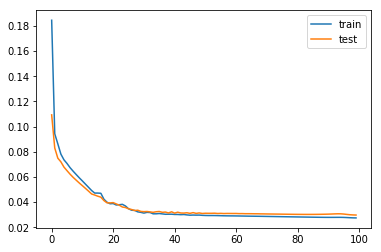

In [20]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size = len(train_X)//10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 37260 samples, validate on 24840 samples
Epoch 1/50
 - 21s - loss: 0.0274 - val_loss: 0.0297
Epoch 2/50
 - 22s - loss: 0.0274 - val_loss: 0.0297
Epoch 3/50
 - 23s - loss: 0.0273 - val_loss: 0.0296
Epoch 4/50
 - 21s - loss: 0.0273 - val_loss: 0.0295
Epoch 5/50
 - 26s - loss: 0.0272 - val_loss: 0.0294
Epoch 6/50
 - 25s - loss: 0.0271 - val_loss: 0.0294
Epoch 7/50
 - 22s - loss: 0.0270 - val_loss: 0.0293
Epoch 8/50
 - 27s - loss: 0.0270 - val_loss: 0.0292
Epoch 9/50
 - 26s - loss: 0.0269 - val_loss: 0.0293
Epoch 10/50
 - 24s - loss: 0.0274 - val_loss: 0.0302
Epoch 11/50
 - 24s - loss: 0.0273 - val_loss: 0.0297
Epoch 12/50
 - 26s - loss: 0.0277 - val_loss: 0.0312
Epoch 13/50
 - 29s - loss: 0.0270 - val_loss: 0.0300
Epoch 14/50
 - 30s - loss: 0.0267 - val_loss: 0.0292
Epoch 15/50
 - 31s - loss: 0.0267 - val_loss: 0.0288
Epoch 16/50
 - 33s - loss: 0.0262 - val_loss: 0.0285
Epoch 17/50
 - 28s - loss: 0.0263 - val_loss: 0.0287
Epoch 18/50
 - 25s - loss: 0.0267 - val_loss: 0.0297
Epoch

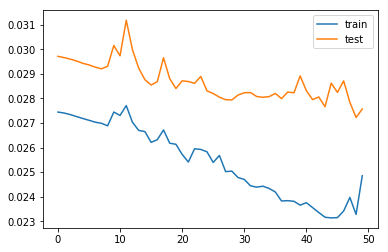

In [26]:
history = model.fit(train_X, train_y, epochs=50, batch_size = len(train_X)//10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 37260 samples, validate on 24840 samples
Epoch 1/50
 - 17s - loss: 0.0245 - val_loss: 0.0278
Epoch 2/50
 - 20s - loss: 0.0238 - val_loss: 0.0289
Epoch 3/50
 - 20s - loss: 0.0242 - val_loss: 0.0279
Epoch 4/50
 - 19s - loss: 0.0239 - val_loss: 0.0272
Epoch 5/50
 - 21s - loss: 0.0232 - val_loss: 0.0266
Epoch 6/50
 - 24s - loss: 0.0231 - val_loss: 0.0271
Epoch 7/50
 - 26s - loss: 0.0226 - val_loss: 0.0268
Epoch 8/50
 - 25s - loss: 0.0224 - val_loss: 0.0268
Epoch 9/50
 - 24s - loss: 0.0223 - val_loss: 0.0273
Epoch 10/50
 - 25s - loss: 0.0227 - val_loss: 0.0273
Epoch 11/50
 - 26s - loss: 0.0228 - val_loss: 0.0273
Epoch 12/50
 - 30s - loss: 0.0235 - val_loss: 0.0277
Epoch 13/50
 - 28s - loss: 0.0230 - val_loss: 0.0282
Epoch 14/50
 - 25s - loss: 0.0233 - val_loss: 0.0267
Epoch 15/50
 - 24s - loss: 0.0225 - val_loss: 0.0277
Epoch 16/50
 - 29s - loss: 0.0222 - val_loss: 0.0269
Epoch 17/50
 - 35s - loss: 0.0218 - val_loss: 0.0270
Epoch 18/50
 - 29s - loss: 0.0219 - val_loss: 0.0269
Epoch

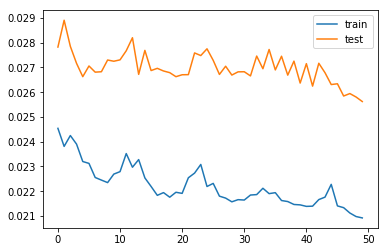

In [30]:
history = model.fit(train_X, train_y, epochs=50, batch_size = len(train_X)//10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
# model.save('lstm_model_all.h5')

In [151]:
# plt.figure(figsize=(20,5))
# yhat = model.predict(testt_X)
# # plt.plot(X_test.reshape(len(X_test),1)[:100], label = 'input')
# plt.plot(yhat, label = 'prediction')
# plt.plot(testt_y, label = 'actual')
# plt.legend()
# plt.grid(True)
# plt.show()

In [152]:
# plt.figure(figsize=(20,5))
# plt.plot(yhat[300:400], label = 'prediction')
# plt.plot(testt_y[300:400], label = 'actual')
# plt.legend()
# plt.grid(True)
# plt.show()

In [39]:
# # make a prediction
yhat = model.predict(testt_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, testt_X[:,0,1:]), axis=1)
inv_yhat.shape
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
testt_y = testt_y.reshape((len(testt_y), 1))
inv_y = concatenate((testt_y, testt_X[:,0,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Baseline RMSE: %.3f' % sqrt(mean_squared_error(inv_y[1:], inv_y[:-1])))

Test RMSE: 0.168
Baseline RMSE: 0.180
